In [1]:
#!pip install qiskit
#!pip install qutip

In [2]:
# import relevant modules
import numpy as np
import pylab
from typing import List 
import qutip as qt
# and from qiskit
from numbers import Number
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.extensions import HamiltonianGate
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit import  ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Operator
from qiskit.providers.fake_provider import FakeVigo
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.opflow import I, X, Y, Z
from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, Parameter, ParameterExpression, ParameterVector
from qiskit.quantum_info.operators.predicates import matrix_equal, is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError
from qiskit.extensions.unitary import UnitaryGate
from qiskit.utils.mitigation import CompleteMeasFitter

In [3]:
# H2 operator for 2 qubits
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [4]:
# Calculating result classically
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


In [5]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [6]:
# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, label=None):
        if isinstance(time, Number) and time != np.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3], label=label)

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3+c]) * np.array(qt.tensor(ops_to_tensor)) #+= 

        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeff0=h_coeff0,h_coeff1=h_coeff1,h_coeff2 = h_coeff2,h_coeff3 = h_coeff3, label=label), qubits, [])

QuantumCircuit.custom_hamiltonian = custom_hamiltonian

In [7]:
# The h_coeffs are parametrised but constant across each analog block
# The time varies across each analog block
# Each digital gate is a universal gate with 3 parameters
def create_ansatz_with_fixed_hamiltonian(no_iters):
    no_qubits = 2
    p = ParameterVector('p', 7 * no_iters + 7) 
    qr = QuantumRegister(no_qubits)
    ansatz = QuantumCircuit(qr)
    ansatz.u(p[0],p[1],p[2],0)
    ansatz.u(p[3],p[4],p[5],1)
    for i in range(1,no_iters+1):
        ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeff0=p[6], h_coeff1=1.0, h_coeff2=1.0 ,h_coeff3=1.0, time=p[7*i], qubits=[qr[0], qr[1]], label='analog block')
        ansatz.u(p[7*i+1],p[7*i+2],p[7*i+3],0)
        ansatz.u(p[7*i+4],p[7*i+5],p[7*i+6],1)
    ansatz.barrier()
    return ansatz

# Sample ansatz with 2 iterations (DADAD)
print(create_ansatz_with_fixed_hamiltonian(2))

      ┌───────────────────┐┌───────────────────────────────────────────┐»
q0_0: ┤ U(p[0],p[1],p[2]) ├┤0                                          ├»
      ├───────────────────┤│  analog block(p[7],2,[[0, 1]],p[6],1,1,1) │»
q0_1: ┤ U(p[3],p[4],p[5]) ├┤1                                          ├»
      └───────────────────┘└───────────────────────────────────────────┘»
«       ┌────────────────────┐ ┌────────────────────────────────────────────┐»
«q0_0: ─┤ U(p[8],p[9],p[10]) ├─┤0                                           ├»
«      ┌┴────────────────────┴┐│  analog block(p[14],2,[[0, 1]],p[6],1,1,1) │»
«q0_1: ┤ U(p[11],p[12],p[13]) ├┤1                                           ├»
«      └──────────────────────┘└────────────────────────────────────────────┘»
«      ┌──────────────────────┐ ░ 
«q0_0: ┤ U(p[15],p[16],p[17]) ├─░─
«      ├──────────────────────┤ ░ 
«q0_1: ┤ U(p[18],p[19],p[20]) ├─░─
«      └──────────────────────┘ ░ 


In [8]:
# The h_coeffs are parametrised and can vary across each analog block
# The time varies across each analog block
# Each digital gate is a universal gate with 3 parameters
def create_ansatz_with_variable_hamiltonian(no_iters):
    no_qubits = 2
    p = ParameterVector('p', 8*no_iters+6) 
    qr = QuantumRegister(no_qubits)
    ansatz = QuantumCircuit(qr)
    ansatz.u(p[0],p[1],p[2],0)
    ansatz.u(p[3],p[4],p[5],1)
    for i in range(1,no_iters+1):
        ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeff0=p[8*i-1], h_coeff1=1.0, h_coeff2=1.0 ,h_coeff3=1.0, time=p[8*i-2], qubits=[qr[0], qr[1]], label='analog block')
        ansatz.u(p[8*i],p[8*i+1],p[8*i+2],0)
        ansatz.u(p[8*i+3],p[8*i+4],p[8*i+5],1)
    ansatz.barrier()
    return ansatz
# Sample ansatz with 2 iterations (DADAD)
print(create_ansatz_with_variable_hamiltonian(2))

      ┌───────────────────┐┌───────────────────────────────────────────┐»
q1_0: ┤ U(p[0],p[1],p[2]) ├┤0                                          ├»
      ├───────────────────┤│  analog block(p[6],2,[[0, 1]],p[7],1,1,1) │»
q1_1: ┤ U(p[3],p[4],p[5]) ├┤1                                          ├»
      └───────────────────┘└───────────────────────────────────────────┘»
«       ┌────────────────────┐ ┌─────────────────────────────────────────────┐»
«q1_0: ─┤ U(p[8],p[9],p[10]) ├─┤0                                            ├»
«      ┌┴────────────────────┴┐│  analog block(p[14],2,[[0, 1]],p[15],1,1,1) │»
«q1_1: ┤ U(p[11],p[12],p[13]) ├┤1                                            ├»
«      └──────────────────────┘└─────────────────────────────────────────────┘»
«      ┌──────────────────────┐ ░ 
«q1_0: ┤ U(p[16],p[17],p[18]) ├─░─
«      ├──────────────────────┤ ░ 
«q1_1: ┤ U(p[19],p[20],p[21]) ├─░─
«      └──────────────────────┘ ░ 


In [9]:
# The h_coeffs are fixed
# The time varies across each analog block
# Each digital gate is a universal gate with 3 parameters
def create_ansatz_without_h_coeffs(no_iters):
    no_qubits = 2
    p = ParameterVector('p', 7*no_iters+6)
    qr = QuantumRegister(no_qubits)
    ansatz = QuantumCircuit(qr)
    hamiltonian = create_zz_hamiltonian(no_qubits, [[0, 1]], [1.]) 
    ansatz.u(p[0],p[1],p[2],0)
    ansatz.u(p[3],p[4],p[5],1)
    for i in range(1,no_iters+1):
        ansatz.hamiltonian(operator=hamiltonian, time=p[7*i-1], qubits=[qr[0], qr[1]], label='analog block')
        ansatz.u(p[7*i],p[7*i+1],p[7*i+2],0)
        ansatz.u(p[7*i+3],p[7*i+4],p[7*i+5],1)
    ansatz.barrier()
    return ansatz
# Sample ansatz with 2 iterations (DADAD)
print(create_ansatz_without_h_coeffs(2))

      ┌───────────────────┐┌───────────────┐ ┌───────────────────┐  »
q2_0: ┤ U(p[0],p[1],p[2]) ├┤0              ├─┤ U(p[7],p[8],p[9]) ├──»
      ├───────────────────┤│  analog block │┌┴───────────────────┴─┐»
q2_1: ┤ U(p[3],p[4],p[5]) ├┤1              ├┤ U(p[10],p[11],p[12]) ├»
      └───────────────────┘└───────────────┘└──────────────────────┘»
«      ┌───────────────┐┌──────────────────────┐ ░ 
«q2_0: ┤0              ├┤ U(p[14],p[15],p[16]) ├─░─
«      │  analog block │├──────────────────────┤ ░ 
«q2_1: ┤1              ├┤ U(p[17],p[18],p[19]) ├─░─
«      └───────────────┘└──────────────────────┘ ░ 


In [10]:
# The ansatz is created solely with digital gates as a benchmark
# Each digital block is represented as is
# Each analog block is represented as a pair of cz gates
def create_ansatz_with_digital_methods(no_iters):  
    no_qubits = 2
    p = ParameterVector('p',6 * (no_iters + 1))
    ansatz = QuantumCircuit(no_qubits)
    ansatz.u(p[0],p[1],p[2],0)
    ansatz.u(p[3],p[4],p[5],1)
    for i in range(1,no_iters+1):
        ansatz.cz(0,1)
        ansatz.cz(1,0)
        ansatz.u(p[6*i],p[6*i+1],p[6*i+2],0)
        ansatz.u(p[6*i+3],p[6*i+4],p[6*i+5],1)
    ansatz.barrier()
    return ansatz
# Sample ansatz with digital gates
print(create_ansatz_with_digital_methods(2))

     ┌───────────────────┐       ┌───────────────────┐       »
q_0: ┤ U(p[0],p[1],p[2]) ├─■──■──┤ U(p[6],p[7],p[8]) ├──■──■─»
     ├───────────────────┤ │  │ ┌┴───────────────────┴┐ │  │ »
q_1: ┤ U(p[3],p[4],p[5]) ├─■──■─┤ U(p[9],p[10],p[11]) ├─■──■─»
     └───────────────────┘      └─────────────────────┘      »
«     ┌──────────────────────┐ ░ 
«q_0: ┤ U(p[12],p[13],p[14]) ├─░─
«     ├──────────────────────┤ ░ 
«q_1: ┤ U(p[15],p[16],p[17]) ├─░─
«     └──────────────────────┘ ░ 


In [11]:
# This function simulates a given ansatz in 3 different ways:
# 1) Noise-free
# 2) Noisy
# 3) Noise and error mitigated
def run_ansatz(ansatz):
    seed = 170
    iterations = 125
    # learning_rate = 0.001
    # perturbation = 0.001
    # spsa = SPSA(maxiter=iterations, learning_rate = learning_rate, perturbation = perturbation)
    spsa = SPSA(maxiter=iterations)
    algorithm_globals.random_seed = seed
    backend = Aer.get_backend('aer_simulator')
    
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')
    print()
    
    device_backend = FakeVigo()
    backend = Aer.get_backend('aer_simulator')
    counts1 = []
    values1 = []
    device = QasmSimulator.from_backend(device_backend)
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)
    basis_gates = noise_model.basis_gates

    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                        coupling_map=coupling_map, noise_model=noise_model,)

    def store_intermediate_result1(eval_count, parameters, mean, std):
        counts1.append(eval_count)
        values1.append(mean)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
    result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')
    print()
   
    counts2 = []
    values2 = []
    if noise_model is not None:
        algorithm_globals.random_seed = seed
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                            coupling_map=coupling_map, noise_model=noise_model, 
                            measurement_error_mitigation_cls=CompleteMeasFitter, 
                            cals_matrix_refresh_period=30)

        def store_intermediate_result2(eval_count, parameters, mean, std):
            counts2.append(eval_count)
            values2.append(mean)
        vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
        result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
        print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
        print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')
        print()

In [12]:
def run_ansatz_with_graphs(ansatz):
    seed = 170
    iterations = 125
    # learning_rate = 0.001
    # perturbation = 0.001
    # spsa = SPSA(maxiter=iterations, learning_rate = learning_rate, perturbation = perturbation)
    spsa = SPSA(maxiter=iterations)
    algorithm_globals.random_seed = seed
    backend = Aer.get_backend('aer_simulator')
    
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')
    print()
    
    device_backend = FakeVigo()
    backend = Aer.get_backend('aer_simulator')
    counts1 = []
    values1 = []
    device = QasmSimulator.from_backend(device_backend)
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)
    basis_gates = noise_model.basis_gates

    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                        coupling_map=coupling_map, noise_model=noise_model,)

    def store_intermediate_result1(eval_count, parameters, mean, std):
        counts1.append(eval_count)
        values1.append(mean)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
    result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')
    print()
   
    counts2 = []
    values2 = []
    if noise_model is not None:
        algorithm_globals.random_seed = seed
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                            coupling_map=coupling_map, noise_model=noise_model, 
                            measurement_error_mitigation_cls=CompleteMeasFitter, 
                            cals_matrix_refresh_period=30)

        def store_intermediate_result2(eval_count, parameters, mean, std):
            counts2.append(eval_count)
            values2.append(mean)
        vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
        result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
        print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
        print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')
        print()
    
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts, values, "b")
    pylab.plot(counts1, values1, "g")
    pylab.plot(counts2, values2, "r")
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Noiseless (Blue), noisy (Green) and noise and error mitigated (Red) simulation')

VQE on Aer qasm simulator (no noise): -1.85496
Delta from reference energy value is 0.00231

VQE on Aer qasm simulator (with noise): -1.80451
Delta from reference energy value is 0.05276

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.86186
Delta from reference energy value is -0.00458



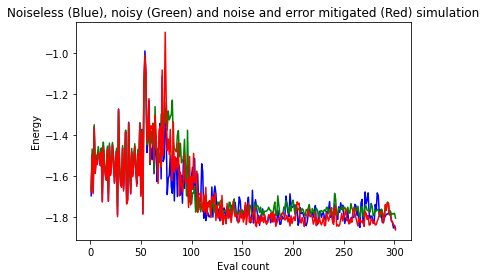

In [13]:
# Sample graph
run_ansatz_with_graphs(create_ansatz_without_h_coeffs(2))

In [14]:
for i in range(1,4):
    print("Simulating our code with", i, "iterations:\n")
    run_ansatz(create_ansatz_with_fixed_hamiltonian(i))

Simulating our code with 1 iterations:

VQE on Aer qasm simulator (no noise): -1.83944
Delta from reference energy value is 0.01783

VQE on Aer qasm simulator (with noise): -1.79012
Delta from reference energy value is 0.06716

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84323
Delta from reference energy value is 0.01404

Simulating our code with 2 iterations:

VQE on Aer qasm simulator (no noise): -1.82042
Delta from reference energy value is 0.03686

VQE on Aer qasm simulator (with noise): -1.79047
Delta from reference energy value is 0.06681

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84345
Delta from reference energy value is 0.01382

Simulating our code with 3 iterations:

VQE on Aer qasm simulator (no noise): -1.80806
Delta from reference energy value is 0.04921

VQE on Aer qasm simulator (with noise): -1.72449
Delta from reference energy value is 0.13279

VQE on Aer qasm simulator (with noise and measurement error 

In [15]:
for i in range(1,4):
    print("Simulating our code with", i, "iterations:\n")
    run_ansatz(create_ansatz_with_variable_hamiltonian(i))

Simulating our code with 1 iterations:

VQE on Aer qasm simulator (no noise): -1.83944
Delta from reference energy value is 0.01783

VQE on Aer qasm simulator (with noise): -1.79012
Delta from reference energy value is 0.06716

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84323
Delta from reference energy value is 0.01404

Simulating our code with 2 iterations:

VQE on Aer qasm simulator (no noise): -1.81176
Delta from reference energy value is 0.04551

VQE on Aer qasm simulator (with noise): -1.78922
Delta from reference energy value is 0.06806

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84495
Delta from reference energy value is 0.01232

Simulating our code with 3 iterations:

VQE on Aer qasm simulator (no noise): -1.80845
Delta from reference energy value is 0.04882

VQE on Aer qasm simulator (with noise): -1.51285
Delta from reference energy value is 0.34442

VQE on Aer qasm simulator (with noise and measurement error 

In [16]:
for i in range(1,4):
    print("Simulating our code with", i, "iterations:\n")
    run_ansatz(create_ansatz_without_h_coeffs(i))

Simulating our code with 1 iterations:

VQE on Aer qasm simulator (no noise): -1.85223
Delta from reference energy value is 0.00504

VQE on Aer qasm simulator (with noise): -1.79643
Delta from reference energy value is 0.06085

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.86489
Delta from reference energy value is -0.00761

Simulating our code with 2 iterations:

VQE on Aer qasm simulator (no noise): -1.85496
Delta from reference energy value is 0.00231

VQE on Aer qasm simulator (with noise): -1.80451
Delta from reference energy value is 0.05276

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.86186
Delta from reference energy value is -0.00458

Simulating our code with 3 iterations:

VQE on Aer qasm simulator (no noise): -1.85019
Delta from reference energy value is 0.00709

VQE on Aer qasm simulator (with noise): -1.79716
Delta from reference energy value is 0.06012

VQE on Aer qasm simulator (with noise and measurement erro

In [17]:
for i in range(1,4):
    print("Simulating our code with", i, "iterations:\n")
    run_ansatz(create_ansatz_with_digital_methods(i))

Simulating our code with 1 iterations:

VQE on Aer qasm simulator (no noise): -1.83934
Delta from reference energy value is 0.01793

VQE on Aer qasm simulator (with noise): -1.78785
Delta from reference energy value is 0.06942

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84116
Delta from reference energy value is 0.01611

Simulating our code with 2 iterations:

VQE on Aer qasm simulator (no noise): -1.83934
Delta from reference energy value is 0.01793

VQE on Aer qasm simulator (with noise): -1.78936
Delta from reference energy value is 0.06791

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.84253
Delta from reference energy value is 0.01475

Simulating our code with 3 iterations:

VQE on Aer qasm simulator (no noise): -1.83899
Delta from reference energy value is 0.01828

VQE on Aer qasm simulator (with noise): -1.78830
Delta from reference energy value is 0.06897

VQE on Aer qasm simulator (with noise and measurement error 